<a href="https://colab.research.google.com/github/yejoonlee/TSA_Projects/blob/main/TSA_practice/1_create_time_feature.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 해당 파일은 시계열 데이터 특성을 활용하여 이미 가진 feature에서 시계열 패턴을 추출하는 코드 상세이다.

## **0. Result Code**

In [ ]:
### Feature engineering of all
def feature_engineering(raw):
    raw_fe = raw.copy()
    if 'datetime' in raw_fe.columns:
        raw_fe['datetime'] = pd.to_datetime(raw_fe['datetime'])
        raw_fe['DateTime'] = pd.to_datetime(raw_fe['datetime'])

    if raw_fe.index.dtype == 'int64':
        raw_fe.set_index('DateTime', inplace=True)

    raw_fe = raw_fe.asfreq('H', method='ffill')

    result = sm.tsa.seasonal_decompose(raw_fe['count'], model='additive')
    Y_trend = pd.DataFrame(result.trend)
    Y_trend.fillna(method='ffill', inplace=True)
    Y_trend.fillna(method='bfill', inplace=True)
    Y_trend.columns = ['count_trend']
    Y_seasonal = pd.DataFrame(result.seasonal)
    Y_seasonal.fillna(method='ffill', inplace=True)
    Y_seasonal.fillna(method='bfill', inplace=True)
    Y_seasonal.columns = ['count_seasonal']
    pd.concat([raw_fe, Y_trend, Y_seasonal], axis=1).isnull().sum()
    if 'count_trend' not in raw_fe.columns:
        if 'count_seasonal' not in raw_fe.columns:
            raw_fe = pd.concat([raw_fe, Y_trend, Y_seasonal], axis=1)

    Y_count_Day = raw_fe[['count']].rolling(24).mean()
    Y_count_Day.fillna(method='ffill', inplace=True)
    Y_count_Day.fillna(method='bfill', inplace=True)
    Y_count_Day.columns = ['count_Day']
    Y_count_Week = raw_fe[['count']].rolling(24*7).mean()
    Y_count_Week.fillna(method='ffill', inplace=True)
    Y_count_Week.fillna(method='bfill', inplace=True)
    Y_count_Week.columns = ['count_Week']
    if 'count_Day' not in raw_fe.columns:
        raw_fe = pd.concat([raw_fe, Y_count_Day], axis=1)
    if 'count_Week' not in raw_fe.columns:
        raw_fe = pd.concat([raw_fe, Y_count_Week], axis=1)

    Y_diff = raw_fe[['count']].diff()
    Y_diff.fillna(method='ffill', inplace=True)
    Y_diff.fillna(method='bfill', inplace=True)
    Y_diff.columns = ['count_diff']
    if 'count_diff' not in raw_fe.columns:
        raw_fe = pd.concat([raw_fe, Y_diff], axis=1)

    raw_fe['temp_group'] = pd.cut(raw_fe['temp'], 10)
    raw_fe['Year'] = raw_fe.datetime.dt.year
    raw_fe['Quater'] = raw_fe.datetime.dt.quarter
    raw_fe['Quater_ver2'] = raw_fe['Quater'] + (raw_fe.Year - raw_fe.Year.min()) * 4
    raw_fe['Month'] = raw_fe.datetime.dt.month
    raw_fe['Day'] = raw_fe.datetime.dt.day
    raw_fe['Hour'] = raw_fe.datetime.dt.hour
    raw_fe['DayofWeek'] = raw_fe.datetime.dt.dayofweek

    raw_fe['count_lag1'] = raw_fe['count'].shift(1)
    raw_fe['count_lag2'] = raw_fe['count'].shift(2)
    raw_fe['count_lag1'].fillna(method='bfill', inplace=True)
    raw_fe['count_lag2'].fillna(method='bfill', inplace=True)

    if 'Quater' in raw_fe.columns:
        if 'Quater_Dummy' not in ['_'.join(col.split('_')[:2]) for col in raw_fe.columns]:
            raw_fe = pd.concat([raw_fe, pd.get_dummies(raw_fe['Quater'], prefix='Quater_Dummy', drop_first=True)], axis=1)
            del raw_fe['Quater']
    return raw_fe
# raw_fe = feature_engineering(raw_all)

## **1. Import Library**

In [ ]:
!python -m pip install --user --upgrade pip

In [ ]:
# Ignore the warnings
import warnings
# warnings.filterwarnings('always')
warnings.filterwarnings('ignore')

# System related and data input controls
import os

# Data manipulation and visualization
import pandas as pd
pd.options.display.float_format = '{:,.2f}'.format
pd.options.display.max_rows = 10
pd.options.display.max_columns = 20
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Modeling algorithms
# General
import statsmodels.api as sm
from scipy import stats

# Model selection
from sklearn.model_selection import train_test_split

# Evaluation metrics
# for regression
from sklearn.metrics import mean_squared_log_error, mean_squared_error,  r2_score, mean_absolute_error

## **2. Load Data**

In [ ]:
# mount google drive
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# copy the path to data and read by pandas
location = '/content/drive/MyDrive/Colab Notebooks/practice/TSA_Practice/Data/BikeSharingDemand/Bike_Sharing_Demand_Full.csv'
raw_all = pd.read_csv(location)
raw_all

,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,count
0,2011-01-01 0:00,1,0,0,1,9.84,14.39,81,0.00,3,13,16
1,2011-01-01 1:00,1,0,0,1,9.02,13.63,80,0.00,8,32,40
2,2011-01-01 2:00,1,0,0,1,9.02,13.63,80,0.00,5,27,32
3,2011-01-01 3:00,1,0,0,1,9.84,14.39,75,0.00,3,10,13
4,2011-01-01 4:00,1,0,0,1,9.84,14.39,75,0.00,0,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...
17374,2012-12-31 19:00,1,0,1,2,10.66,12.88,60,11.00,11,108,119
17375,2012-12-31 20:00,1,0,1,2,10.66,12.88,60,11.00,8,81,89
17376,2012-12-31 21:00,1,0,1,1,10.66,12.88,60,11.00,7,83,90
17377,2012-12-31 22:00,1,0,1,1,10.66,13.63,56,9.00,13,48,61


## **3. Feature Engineering(Rearrange of Data)**

In [ ]:
# 데이터에 대한 기본적인 통계 정보와
print('[ column별 기본적 통계 정보 ]')
display(raw_all.describe(include='all').T)
raw_all.info()

print('\n\n==============================')
print('\n[ 데이터 형태 및 실제 데이터를 확인 ]')
print(f"""
shape : {raw_all.shape}
ndim : {raw_all.ndim}
""")
display(raw_all.head())
display(raw_all.tail())

[ column별 기본적 통계 정보 ]


,count,unique,top,freq,mean,std,min,25%,50%,75%,max
datetime,17379,17379,2012-09-25 9:00,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN
season,"17,379.00",NaN,NaN,NaN,2.50,1.11,1.00,2.00,3.00,3.00,4.00
holiday,"17,379.00",NaN,NaN,NaN,0.03,0.17,0.00,0.00,0.00,0.00,1.00
workingday,"17,379.00",NaN,NaN,NaN,0.68,0.47,0.00,0.00,1.00,1.00,1.00
weather,"17,379.00",NaN,NaN,NaN,1.43,0.64,1.00,1.00,1.00,2.00,4.00
...,...,...,...,...,...,...,...,...,...,...,...
humidity,"17,379.00",NaN,NaN,NaN,62.72,19.29,0.00,48.00,63.00,78.00,100.00
windspeed,"17,379.00",NaN,NaN,NaN,12.74,8.20,0.00,7.00,13.00,17.00,57.00
casual,"17,379.00",NaN,NaN,NaN,35.68,49.31,0.00,4.00,17.00,48.00,367.00
registered,"17,379.00",NaN,NaN,NaN,153.79,151.36,0.00,34.00,115.00,220.00,886.00


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17379 entries, 0 to 17378
Data columns (total 12 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   datetime    17379 non-null  object 
 1   season      17379 non-null  int64  
 2   holiday     17379 non-null  int64  
 3   workingday  17379 non-null  int64  
 4   weather     17379 non-null  int64  
 5   temp        17379 non-null  float64
 6   atemp       17379 non-null  float64
 7   humidity    17379 non-null  int64  
 8   windspeed   17379 non-null  float64
 9   casual      17379 non-null  int64  
 10  registered  17379 non-null  int64  
 11  count       17379 non-null  int64  
dtypes: float64(3), int64(8), object(1)
memory usage: 1.6+ MB



[ 데이터 형태 및 실제 데이터를 확인 ]

shape : (17379, 12)
ndim : 2



,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,count
0,2011-01-01 0:00,1,0,0,1,9.84,14.39,81,0.00,3,13,16
1,2011-01-01 1:00,1,0,0,1,9.02,13.63,80,0.00,8,32,40
2,2011-01-01 2:00,1,0,0,1,9.02,13.63,80,0.00,5,27,32
3,2011-01-01 3:00,1,0,0,1,9.84,14.39,75,0.00,3,10,13
4,2011-01-01 4:00,1,0,0,1,9.84,14.39,75,0.00,0,1,1


,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,count
17374,2012-12-31 19:00,1,0,1,2,10.66,12.88,60,11.00,11,108,119
17375,2012-12-31 20:00,1,0,1,2,10.66,12.88,60,11.00,8,81,89
17376,2012-12-31 21:00,1,0,1,1,10.66,12.88,60,11.00,7,83,90
17377,2012-12-31 22:00,1,0,1,1,10.66,13.63,56,9.00,13,48,61
17378,2012-12-31 23:00,1,0,1,1,10.66,13.63,65,9.00,12,37,49


In [ ]:
# 문자열로 정의된 시계열 컬럼을 인덱스로 설정
print(f'1. index.dtype before setting : {raw_all.index.dtype}\n')

if 'datetime' in raw_all.columns:
    raw_all['datetime'] = pd.to_datetime(raw_all['datetime'])
    raw_all['DateTime'] = pd.to_datetime(raw_all['datetime'])
if raw_all.index.dtype == 'int64':
    raw_all.set_index('DateTime', inplace=True)

print(f'2. index.dtype after setting : {raw_all.index.dtype}\n')
# raw_all.info()

raw_all.head()

1. index.dtype before setting : int64

2. index.dtype after setting : datetime64[ns]



,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,count
DateTime,,,,,,,,,,,,
2011-01-01 00:00:00,2011-01-01 00:00:00,1,0,0,1,9.84,14.39,81,0.00,3,13,16
2011-01-01 01:00:00,2011-01-01 01:00:00,1,0,0,1,9.02,13.63,80,0.00,8,32,40
2011-01-01 02:00:00,2011-01-01 02:00:00,1,0,0,1,9.02,13.63,80,0.00,5,27,32
2011-01-01 03:00:00,2011-01-01 03:00:00,1,0,0,1,9.84,14.39,75,0.00,3,10,13
2011-01-01 04:00:00,2011-01-01 04:00:00,1,0,0,1,9.84,14.39,75,0.00,0,1,1


In [ ]:
# null을 포함한 column 확인
print('[ Null in each column ]')
print(raw_all.isnull().sum())
print(f'\nNull in all data : {raw_all.isnull().sum().sum()}')

[ Null in each column ]
datetime      0
season        0
holiday       0
workingday    0
weather       0
             ..
humidity      0
windspeed     0
casual        0
registered    0
count         0
Length: 12, dtype: int64

Null in all data : 0


In [ ]:
# asfreq을 통해 데이터의 기간 중 빈 시간 데이터를 확인 후 가까운 데이터로 빈 데이터를 대체
print(f"empty hours before fill : {raw_all.asfreq('H').isnull().sum().sum()}")

raw_all = raw_all.asfreq('H', method='ffill')

print(f"empty hours after fill : {raw_all.isnull().sum().sum()}")
raw_all.index

empty hours before fill : 1980
empty hours after fill : 0


DatetimeIndex(['2011-01-01 00:00:00', '2011-01-01 01:00:00',
               '2011-01-01 02:00:00', '2011-01-01 03:00:00',
               '2011-01-01 04:00:00', '2011-01-01 05:00:00',
               '2011-01-01 06:00:00', '2011-01-01 07:00:00',
               '2011-01-01 08:00:00', '2011-01-01 09:00:00',
               ...
               '2012-12-31 14:00:00', '2012-12-31 15:00:00',
               '2012-12-31 16:00:00', '2012-12-31 17:00:00',
               '2012-12-31 18:00:00', '2012-12-31 19:00:00',
               '2012-12-31 20:00:00', '2012-12-31 21:00:00',
               '2012-12-31 22:00:00', '2012-12-31 23:00:00'],
              dtype='datetime64[ns]', name='DateTime', length=17544, freq='H')

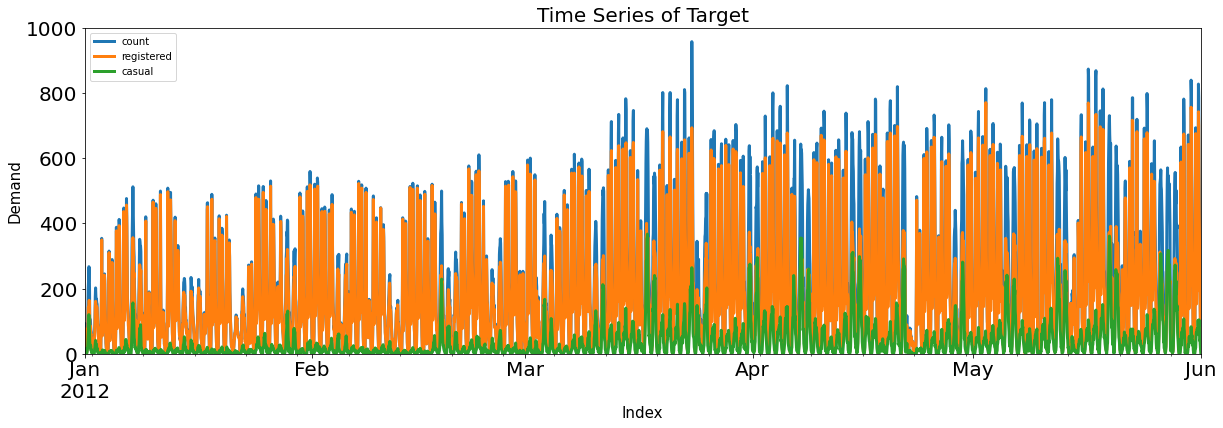

In [ ]:
# 반년 간의 타겟 데이터를 시각화하여 확인
raw_all[['count','registered','casual']].plot(kind='line', figsize=(20,6), linewidth=3, fontsize=20,
                                              xlim=('2012-01-01', '2012-06-01'), ylim=(0,1000))
plt.title('Time Series of Target', fontsize=20)
plt.xlabel('Index', fontsize=15)
plt.ylabel('Demand', fontsize=15)
plt.show()

[ Observed = Trend + Seasonal + Residual ]


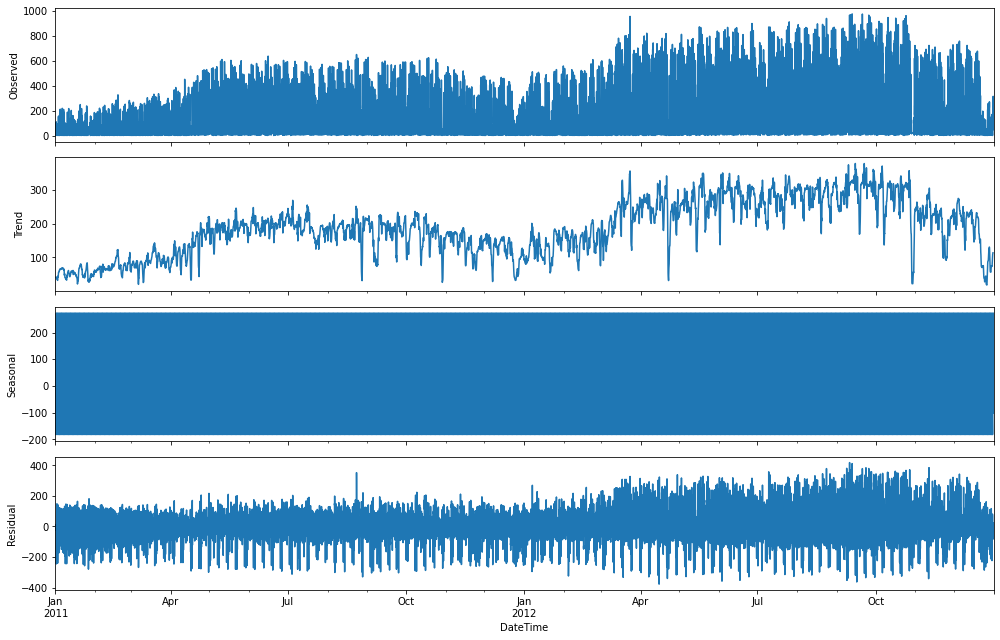

[ Observed = Trend * Seasonal * Residual ]


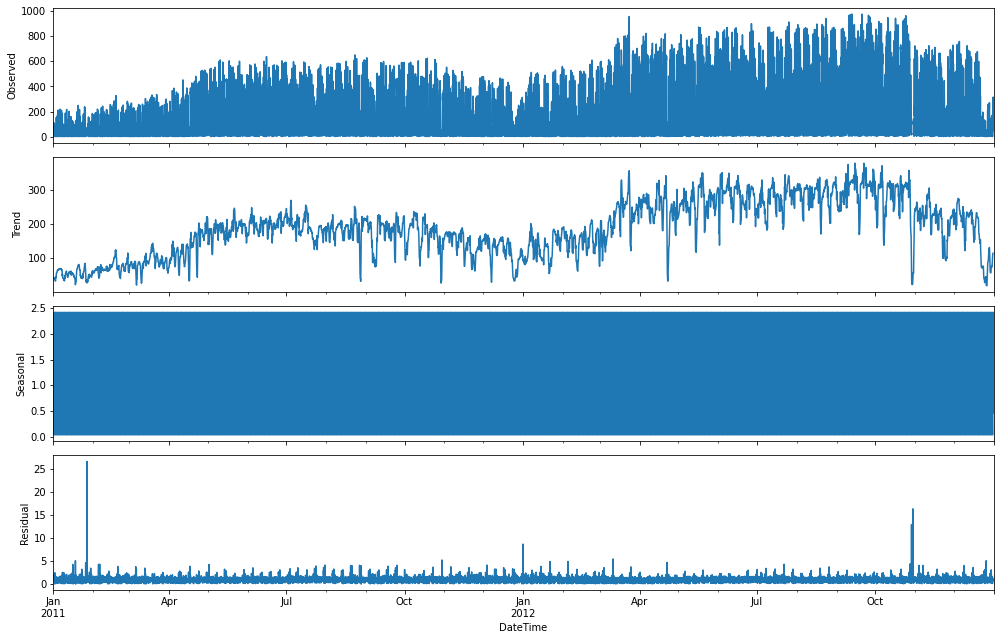

In [ ]:
# sm.tsa.seasonal_decompose을 활용하여 data를 trend + seasonal + residual로 구분
plt.rcParams['figure.figsize'] = (14, 9)
print('[ Observed = Trend + Seasonal + Residual ]')
sm.tsa.seasonal_decompose(raw_all['count'], model='additive').plot()
plt.show()
# sm.tsa.seasonal_decompose을 활용하여 data를 trend * seasonal * residual로 구분
print('[ Observed = Trend * Seasonal * Residual ]')
sm.tsa.seasonal_decompose(raw_all['count'], model='multiplicative').plot()
plt.show()

In [ ]:
# seasonal_decompose를 통해 얻어진 trend와 seasonal 패턴을 하나의 feature로 추가
result = sm.tsa.seasonal_decompose(raw_all['count'], model='additive')
Y_trend = pd.DataFrame(result.trend)
Y_trend.fillna(method='ffill', inplace=True)
Y_trend.fillna(method='bfill', inplace=True)
Y_trend.columns = ['count_trend']
Y_seasonal = pd.DataFrame(result.seasonal)
Y_seasonal.fillna(method='ffill', inplace=True)
Y_seasonal.fillna(method='bfill', inplace=True)
Y_seasonal.columns = ['count_seasonal']

# merging several columns
pd.concat([raw_all, Y_trend, Y_seasonal], axis=1)
print(f'check concat and fill result : {raw_all.isnull().sum().sum()}')

if 'count_trend' not in raw_all.columns:
    if 'count_seasonal' not in raw_all.columns:
        raw_all = pd.concat([raw_all, Y_trend, Y_seasonal], axis=1)

raw_all.columns

check concat and fill result : 0


Index(['datetime', 'season', 'holiday', 'workingday', 'weather', 'temp',
       'atemp', 'humidity', 'windspeed', 'casual', 'registered', 'count',
       'count_trend', 'count_seasonal'],
      dtype='object')

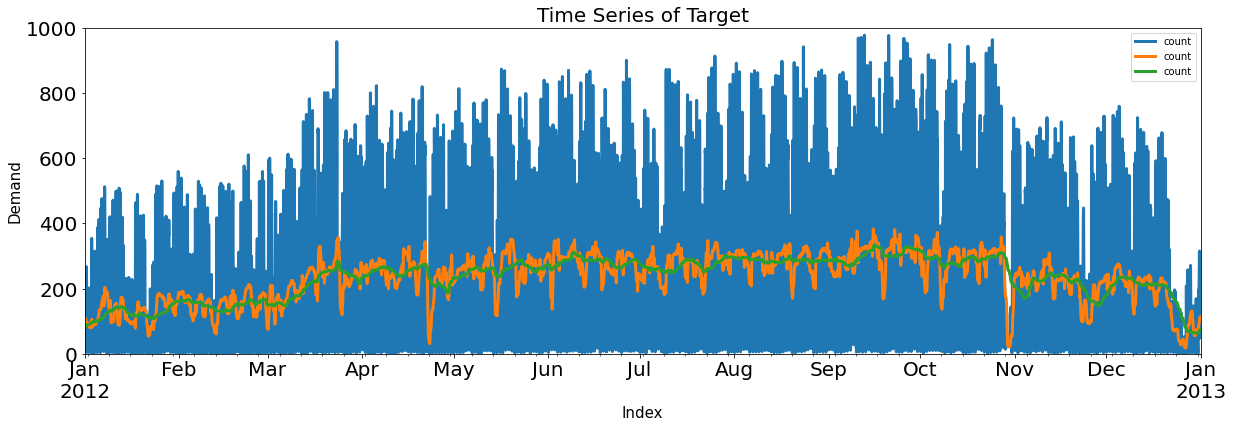

Index(['datetime', 'season', 'holiday', 'workingday', 'weather', 'temp',
       'atemp', 'humidity', 'windspeed', 'casual', 'registered', 'count',
       'count_trend', 'count_seasonal', 'count_Day', 'count_Week'],
      dtype='object')

In [ ]:
# 하루, 일주일 간격으로 이동평균 패턴을 추출하여 확인 및 피쳐로 추가
# comparison of several moving average values
pd.concat([raw_all[['count']],
           raw_all[['count']].rolling(24).mean(),
           raw_all[['count']].rolling(24*7).mean()], axis=1).plot(kind='line', figsize=(20,6), linewidth=3, fontsize=20,
                                                                  xlim=('2012-01-01', '2013-01-01'), ylim=(0,1000))
# print(raw_all.columns)
plt.title('Time Series of Target', fontsize=20)
plt.xlabel('Index', fontsize=15)
plt.ylabel('Demand', fontsize=15)
plt.show()

# fill nan as some values and merging
Y_count_Day = raw_all[['count']].rolling(24).mean()
Y_count_Day.fillna(method='ffill', inplace=True)
Y_count_Day.fillna(method='bfill', inplace=True)
Y_count_Day.columns = ['count_Day']
Y_count_Week = raw_all[['count']].rolling(24*7).mean()
Y_count_Week.fillna(method='ffill', inplace=True)
Y_count_Week.fillna(method='bfill', inplace=True)
Y_count_Week.columns = ['count_Week']
if 'count_Day' not in raw_all.columns:
    raw_all = pd.concat([raw_all, Y_count_Day], axis=1)
if 'count_Week' not in raw_all.columns:
    raw_all = pd.concat([raw_all, Y_count_Week], axis=1)
raw_all.columns

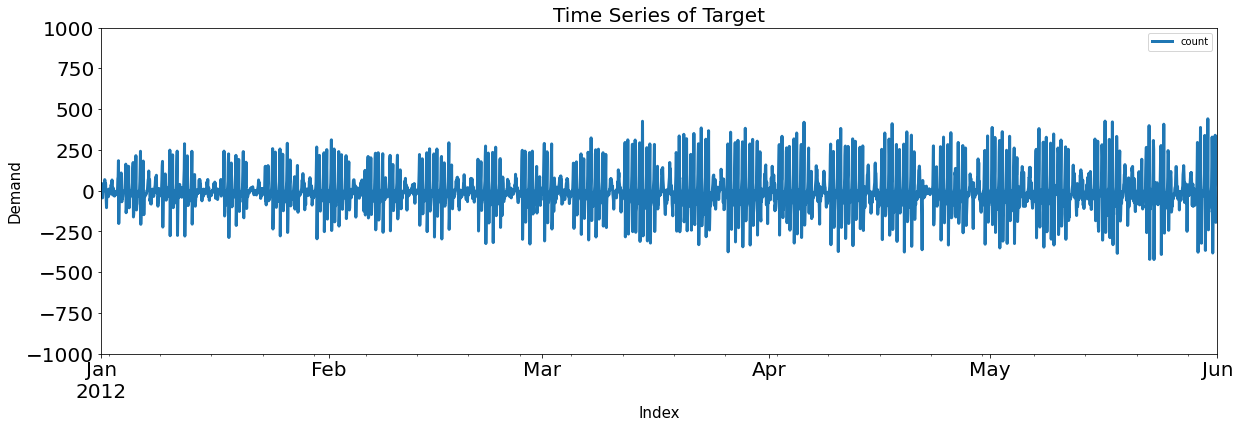

Index(['datetime', 'season', 'holiday', 'workingday', 'weather', 'temp',
       'atemp', 'humidity', 'windspeed', 'casual', 'registered', 'count',
       'count_trend', 'count_seasonal', 'count_Day', 'count_Week',
       'count_diff'],
      dtype='object')

In [ ]:
# 랜덤워크 시계열 데이터 차분을 통해 패턴을 추출하여 확인 및 피쳐로 추가
# line plot of Y for specific periods
raw_all[['count']].diff().plot(kind='line', figsize=(20,6), linewidth=3, fontsize=20,
                                 xlim=('2012-01-01', '2012-06-01'), ylim=(-1000,1000))
plt.title('Time Series of Target', fontsize=20)
plt.xlabel('Index', fontsize=15)
plt.ylabel('Demand', fontsize=15)
plt.show()

# diff of Y and merging
Y_diff = raw_all[['count']].diff()
Y_diff.fillna(method='ffill', inplace=True)
Y_diff.fillna(method='bfill', inplace=True)
Y_diff.columns = ['count_diff']
if 'count_diff' not in raw_all.columns:
    raw_all = pd.concat([raw_all, Y_diff], axis=1)
raw_all.columns

In [ ]:
# Temp와 같이 구간으로 나눌 수 있는 데이터는 cut을 활용하여 패턴 및 피쳐를 추가
raw_all['temp_group'] = pd.cut(raw_all['temp'], 10)
raw_all.describe(include='all').T

,count,unique,top,freq,first,last,mean,std,min,25%,50%,75%,max
datetime,17544,17379,2012-10-29 00:00:00,37,2011-01-01,2012-12-31 23:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN
season,"17,544.00",NaN,NaN,NaN,NaT,NaT,2.50,1.11,1.00,2.00,3.00,3.00,4.00
holiday,"17,544.00",NaN,NaN,NaN,NaT,NaT,0.03,0.17,0.00,0.00,0.00,0.00,1.00
workingday,"17,544.00",NaN,NaN,NaN,NaT,NaT,0.68,0.47,0.00,0.00,1.00,1.00,1.00
weather,"17,544.00",NaN,NaN,NaN,NaT,NaT,1.43,0.65,1.00,1.00,1.00,2.00,4.00
...,...,...,...,...,...,...,...,...,...,...,...,...,...
count_seasonal,"17,544.00",NaN,NaN,NaN,NaT,NaT,0.00,128.50,-181.67,-117.81,21.32,64.69,273.37
count_Day,"17,544.00",NaN,NaN,NaN,NaT,NaT,187.74,80.25,18.04,130.29,188.48,247.42,382.50
count_Week,"17,544.00",NaN,NaN,NaN,NaT,NaT,187.67,73.12,45.95,137.19,185.83,254.88,332.99
count_diff,"17,544.00",NaN,NaN,NaN,NaT,NaT,0.00,100.90,-523.00,-39.00,-4.00,30.00,519.00


In [ ]:
# 연도, 분기, 월, 일, 시간, 요일 등을 피쳐로 추가
raw_all['Year'] = raw_all.datetime.dt.year
raw_all['Quater'] = raw_all.datetime.dt.quarter
raw_all['Quater_ver2'] = raw_all['Quater'] + (raw_all.Year - raw_all.Year.min()) * 4
raw_all['Month'] = raw_all.datetime.dt.month
raw_all['Day'] = raw_all.datetime.dt.day
raw_all['Hour'] = raw_all.datetime.dt.hour
raw_all['DayofWeek'] = raw_all.datetime.dt.dayofweek
raw_all.columns

Index(['datetime', 'season', 'holiday', 'workingday', 'weather', 'temp',
       'atemp', 'humidity', 'windspeed', 'casual', 'registered', 'count',
       'count_trend', 'count_seasonal', 'count_Day', 'count_Week',
       'count_diff', 'temp_group', 'Year', 'Quater', 'Quater_ver2', 'Month',
       'Day', 'Hour', 'DayofWeek'],
      dtype='object')

In [ ]:
# 타겟 데이터의 직전, 두번째 전의 데이터를 시프트하여 피쳐로 추가
# calculation of lags of Y
raw_all['count_lag1'] = raw_all['count'].shift(1)
raw_all['count_lag2'] = raw_all['count'].shift(2)
raw_all['count_lag1'].fillna(method='bfill', inplace=True)
raw_all['count_lag2'].fillna(method='bfill', inplace=True)
raw_all.head()

,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,...,temp_group,Year,Quater,Quater_ver2,Month,Day,Hour,DayofWeek,count_lag1,count_lag2
DateTime,,,,,,,,,,,,,,,,,,,,,
2011-01-01 00:00:00,2011-01-01 00:00:00,1,0,0,1,9.84,14.39,81,0.00,3,...,"(8.856, 12.874]",2011,1,1,1,1,0,5,16.00,16.00
2011-01-01 01:00:00,2011-01-01 01:00:00,1,0,0,1,9.02,13.63,80,0.00,8,...,"(8.856, 12.874]",2011,1,1,1,1,1,5,16.00,16.00
2011-01-01 02:00:00,2011-01-01 02:00:00,1,0,0,1,9.02,13.63,80,0.00,5,...,"(8.856, 12.874]",2011,1,1,1,1,2,5,40.00,16.00
2011-01-01 03:00:00,2011-01-01 03:00:00,1,0,0,1,9.84,14.39,75,0.00,3,...,"(8.856, 12.874]",2011,1,1,1,1,3,5,32.00,40.00
2011-01-01 04:00:00,2011-01-01 04:00:00,1,0,0,1,9.84,14.39,75,0.00,0,...,"(8.856, 12.874]",2011,1,1,1,1,4,5,13.00,32.00


In [ ]:
# 카테고리 데이터는 get_dummies로 onhot incoding
# aka onehot
pd.get_dummies(raw_all['Quater'])
# pd.get_dummies(raw_all['Quater']).describe().T
pd.get_dummies(raw_all['Quater'], prefix='Quater_Dummy')
pd.get_dummies(raw_all['Quater'], prefix='Quater_Dummy', drop_first=True)
pd.concat([raw_all, pd.get_dummies(raw_all['Quater'], prefix='Quater_Dummy', drop_first=True)], axis=1)

# feature extraction using dummy variables
if 'Quater' in raw_all.columns:
    raw_all = pd.concat([raw_all, pd.get_dummies(raw_all['Quater'], prefix='Quater_Dummy', drop_first=True)
], axis=1)
    del raw_all['Quater']
raw_all.columns

Index(['datetime', 'season', 'holiday', 'workingday', 'weather', 'temp',
       'atemp', 'humidity', 'windspeed', 'casual', 'registered', 'count',
       'count_trend', 'count_seasonal', 'count_Day', 'count_Week',
       'count_diff', 'temp_group', 'Year', 'Quater_ver2', 'Month', 'Day',
       'Hour', 'DayofWeek', 'count_lag1', 'count_lag2', 'Quater_Dummy_2',
       'Quater_Dummy_3', 'Quater_Dummy_4'],
      dtype='object')